In [136]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/trip-advisor-hotel-reviews/tripadvisor_hotel_reviews.csv


In [137]:
import pandas as pd
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.layers import Flatten, GRU, Dropout, SimpleRNN,SpatialDropout1D, GlobalAveragePooling1D
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model

import tensorflow as tf
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

## Read Data

In [138]:
df = pd.read_csv('/kaggle/input/trip-advisor-hotel-reviews/tripadvisor_hotel_reviews.csv')
df.shape

(20491, 2)

In [139]:
df['Rating'].value_counts()

5    9054
4    6039
3    2184
2    1793
1    1421
Name: Rating, dtype: int64

## Label Review Rating


*   0 if rating is 1 or 2 or 3
*   1 if rating is 4 or 5

In [140]:
df['label'] = np.array(df['Rating'].apply(lambda x: 1 if x > 3 else 0))
df.head()

,Review,Rating,label
0,nice hotel expensive parking got good deal sta...,4,1
1,ok nothing special charge diamond member hilto...,2,0
2,nice rooms not 4* experience hotel monaco seat...,3,0
3,"unique, great stay, wonderful time hotel monac...",5,1
4,"great stay great stay, went seahawk game aweso...",5,1


## Preprocessing Review Text


*   remove integer values
*   breakdown to words by space delimiter 
*   remove stopwords using nltk library

In [141]:
# nltk.download('stopwords')
stop_words = stopwords.words('english')

In [142]:
def preprocess(text):
    text = re.sub(r'\d+',' ',text)
    text = text.split()
    text = ' '.join([w for w in text if not w.lower().strip() in stop_words])
    return text

In [143]:
df['Review'] = df['Review'].apply(preprocess)

## Training and Testing Data Split

> Split data into train and test datasets with equal proportion of label.

In [144]:

X_train, X_test, y_train, y_test = train_test_split(df['Review'].values,df['label'].values,
                                                    test_size=0.2, random_state=1,stratify=df['label'].values)

## Tokenization

*   convert to lower case (default)
*   remove punctuation
*   integer encoding to word - map each word with unique index for each word with most common as 1 to least common xxx
*   sequence encoding to review
*   NOTE: require data to be str format

AVOID Data Leakage
*  build tokenizer using only training data





In [145]:
NWORDS = 10000
tknz = Tokenizer(num_words=NWORDS,oov_token ="_OOV")
tknz.fit_on_texts(X_train)

train_seq = tknz.texts_to_sequences(X_train)
test_seq = tknz.texts_to_sequences(X_test)

In [146]:
print(len(tknz.word_index))

44178


## Padding
*   get the length of longest review text 
*   set all sequences to a uniform length with the longest review length by filling in with 0 
*   padding flag 'pre': pad 0 in the beginning
*   padding flag 'post': pad 0 in the end



In [147]:
MAX_SEQ_LEN =np.max(list(map(lambda x: len(x), train_seq)))+1
MAX_SEQ_LEN

1941

In [148]:
pad_train_seq = pad_sequences(train_seq,maxlen = MAX_SEQ_LEN, padding='post',truncating='post')
pad_test_seq = pad_sequences(test_seq,maxlen = MAX_SEQ_LEN, padding='post',truncating='post')


## Build Model

In [149]:
EMBED_DIM = 32
BATCH_SIZE = 500
EPOCH = 20

In [150]:
def show_model_summary(model):
  print()
  print(model.summary())
  print()

In [151]:
def build_BiGRU(embedding_dim):
  model = Sequential()
  model.add(Embedding(input_dim=NWORDS, output_dim=embedding_dim,
                      input_length=MAX_SEQ_LEN))
  model.add(Dropout(0.25))
  model.add(Bidirectional(GRU(32)))
  model.add(Dropout(0.1))
  model.add(Flatten())
  model.add(Dense(1,activation='sigmoid'))
  model.compile(optimizer = 'adam', loss = 'binary_crossentropy', 
                metrics = ['accuracy', tf.keras.metrics.AUC(name='auc')])
  
  return model

In [152]:
def fit_model(model, model_name):
  history = model.fit(pad_train_seq,y_train,
                    validation_split=0.2,
                    batch_size=BATCH_SIZE,epochs=EPOCH,
                    callbacks=[
                            EarlyStopping(
                            monitor='val_accuracy',
                            patience=3,
                            restore_best_weights=True
                        )
                        
                    ]
                   )
  model.save(model_name)
  print(pd.DataFrame(model.history.history))
  return history

In [153]:
def plot_PM(history):
  fig = px.line(
    history.history, y = ['auc', 'val_auc','accuracy','val_accuracy'],
    labels={'index': 'Epoch', 'value': 'Accuracy/AUC Score'},
    width = 600, height = 400,
    
  )
  fig.update_layout(legend_title = "Metrics")
  fig.show()


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 1941, 32)          320000    
_________________________________________________________________
dropout_16 (Dropout)         (None, 1941, 32)          0         
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 64)                12672     
_________________________________________________________________
dropout_17 (Dropout)         (None, 64)                0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 332,737
Trainable params: 332,737
Non-trainable params: 0
_______________________________________________

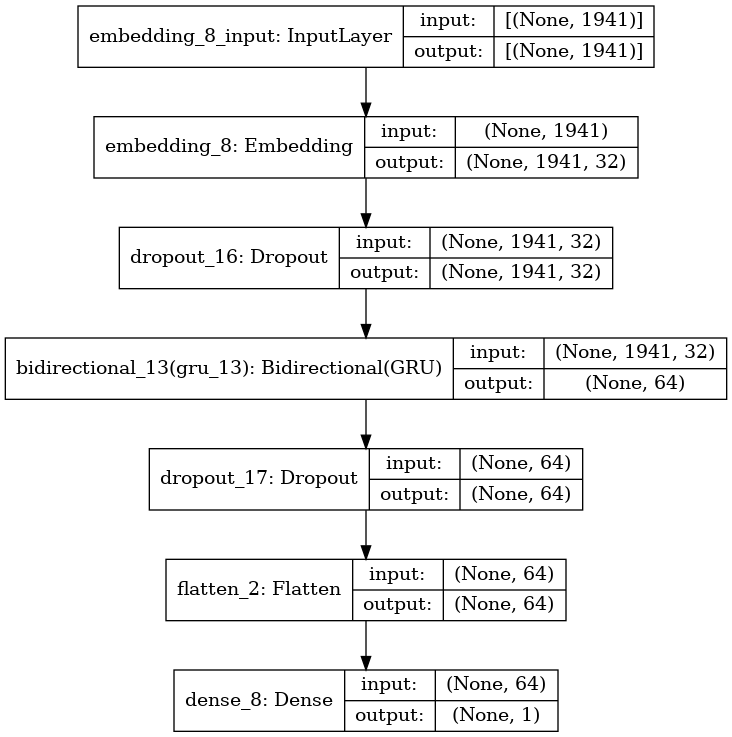

In [154]:
grumodel = build_BiGRU(EMBED_DIM)
show_model_summary(grumodel)
plot_model(grumodel,show_shapes=True)

In [155]:
gruhistory = fit_model(grumodel,'./saved_model/grumodel.h5')
plot_PM(gruhistory)
gru_results = grumodel.evaluate(pad_test_seq,y_test)
gru_results

Epoch 1/20
27/27 [==============================] - 140s 5s/step - loss: 0.6212 - accuracy: 0.7246 - auc: 0.5174 - val_loss: 0.5432 - val_accuracy: 0.7511 - val_auc: 0.8427
Epoch 2/20
27/27 [==============================] - 134s 5s/step - loss: 0.5359 - accuracy: 0.7330 - auc: 0.8073 - val_loss: 0.4696 - val_accuracy: 0.7514 - val_auc: 0.8817
Epoch 3/20
27/27 [==============================] - 133s 5s/step - loss: 0.3935 - accuracy: 0.8032 - auc: 0.8894 - val_loss: 0.3313 - val_accuracy: 0.8539 - val_auc: 0.9136
Epoch 4/20
27/27 [==============================] - 134s 5s/step - loss: 0.2861 - accuracy: 0.8861 - auc: 0.9391 - val_loss: 0.2901 - val_accuracy: 0.8750 - val_auc: 0.9283
Epoch 5/20
27/27 [==============================] - 139s 5s/step - loss: 0.2312 - accuracy: 0.9089 - auc: 0.9593 - val_loss: 0.2807 - val_accuracy: 0.8832 - val_auc: 0.9340
Epoch 6/20
27/27 [==============================] - 136s 5s/step - loss: 0.2053 - accuracy: 0.9235 - auc: 0.9677 - val_loss: 0.2868 - v

129/129 [==============================] - 96s 747ms/step - loss: 0.3259 - accuracy: 0.8624 - auc: 0.9162


[0.32589632272720337, 0.8624054789543152, 0.9161779284477234]

In [156]:
def build_BiGRU_1(embedding_dim):
  model = Sequential()
  model.add(Embedding(input_dim=NWORDS, output_dim=embedding_dim,
                      input_length=MAX_SEQ_LEN))
  model.add(Dropout(0.5))
  model.add(Bidirectional(GRU(32,return_sequences=True)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(1,activation='sigmoid'))
  model.compile(optimizer = 'adam', loss = 'binary_crossentropy', 
                metrics = ['accuracy', tf.keras.metrics.AUC(name='auc')])
  
  return model


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 1941, 32)          320000    
_________________________________________________________________
dropout_18 (Dropout)         (None, 1941, 32)          0         
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 1941, 64)          12672     
_________________________________________________________________
dropout_19 (Dropout)         (None, 1941, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 124224)            0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 124225    
Total params: 456,897
Trainable params: 456,897
Non-trainable params: 0
_______________________________________________

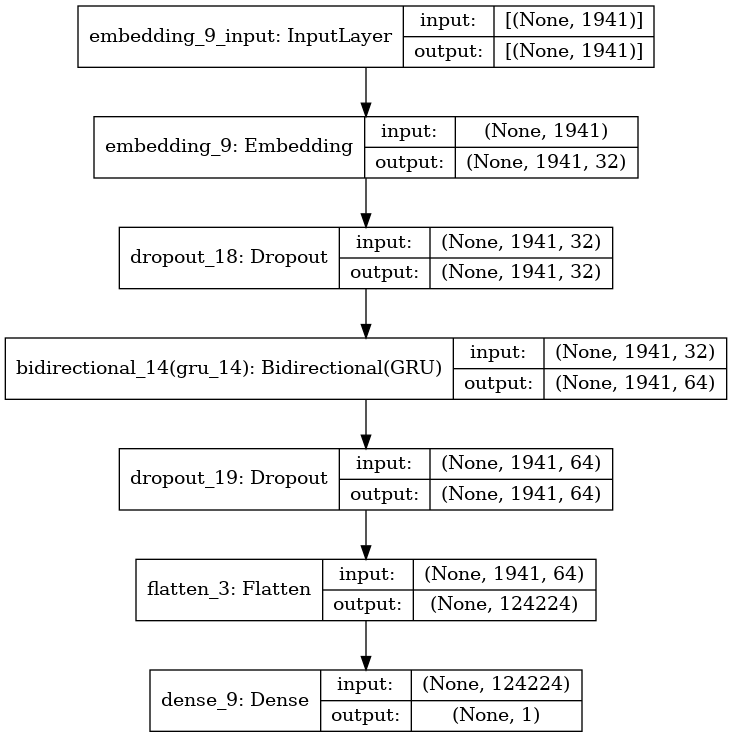

In [157]:
grumodel1 = build_BiGRU_1(EMBED_DIM)
show_model_summary(grumodel1)
plot_model(grumodel1,show_shapes=True)

In [158]:
gruhistory1 = fit_model(grumodel1,'./saved_model/grumodel1.h5')
plot_PM(gruhistory1)
gru_results1 = grumodel1.evaluate(pad_test_seq,y_test)
gru_results1

Epoch 1/20
27/27 [==============================] - 151s 5s/step - loss: 0.5878 - accuracy: 0.7231 - auc: 0.5436 - val_loss: 0.5459 - val_accuracy: 0.7508 - val_auc: 0.7148
Epoch 2/20
27/27 [==============================] - 145s 5s/step - loss: 0.4967 - accuracy: 0.7597 - auc: 0.7951 - val_loss: 0.3589 - val_accuracy: 0.8490 - val_auc: 0.9171
Epoch 3/20
27/27 [==============================] - 145s 5s/step - loss: 0.2872 - accuracy: 0.8824 - auc: 0.9313 - val_loss: 0.2380 - val_accuracy: 0.9048 - val_auc: 0.9491
Epoch 4/20
27/27 [==============================] - 145s 5s/step - loss: 0.2040 - accuracy: 0.9202 - auc: 0.9648 - val_loss: 0.2153 - val_accuracy: 0.9134 - val_auc: 0.9591
Epoch 5/20
27/27 [==============================] - 145s 5s/step - loss: 0.1606 - accuracy: 0.9369 - auc: 0.9776 - val_loss: 0.2290 - val_accuracy: 0.9109 - val_auc: 0.9526
Epoch 6/20
27/27 [==============================] - 144s 5s/step - loss: 0.1334 - accuracy: 0.9482 - auc: 0.9846 - val_loss: 0.2279 - v

129/129 [==============================] - 98s 760ms/step - loss: 0.2995 - accuracy: 0.8978 - auc: 0.9387


[0.2994866967201233, 0.8977799415588379, 0.9387150406837463]

In [159]:
def build_BiGRU_2(embedding_dim):
  model = Sequential()
  model.add(Embedding(input_dim=NWORDS, output_dim=embedding_dim,
                      input_length=MAX_SEQ_LEN))
  model.add(Dropout(0.5))
  model.add(Bidirectional(GRU(64,return_sequences=True)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(1,activation='sigmoid'))
  model.compile(optimizer = 'adam', loss = 'binary_crossentropy', 
                metrics = ['accuracy', tf.keras.metrics.AUC(name='auc')])
  
  return model


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 1941, 32)          320000    
_________________________________________________________________
dropout_20 (Dropout)         (None, 1941, 32)          0         
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 1941, 128)         37632     
_________________________________________________________________
dropout_21 (Dropout)         (None, 1941, 128)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 248448)            0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 248449    
Total params: 606,081
Trainable params: 606,081
Non-trainable params: 0
______________________________________________

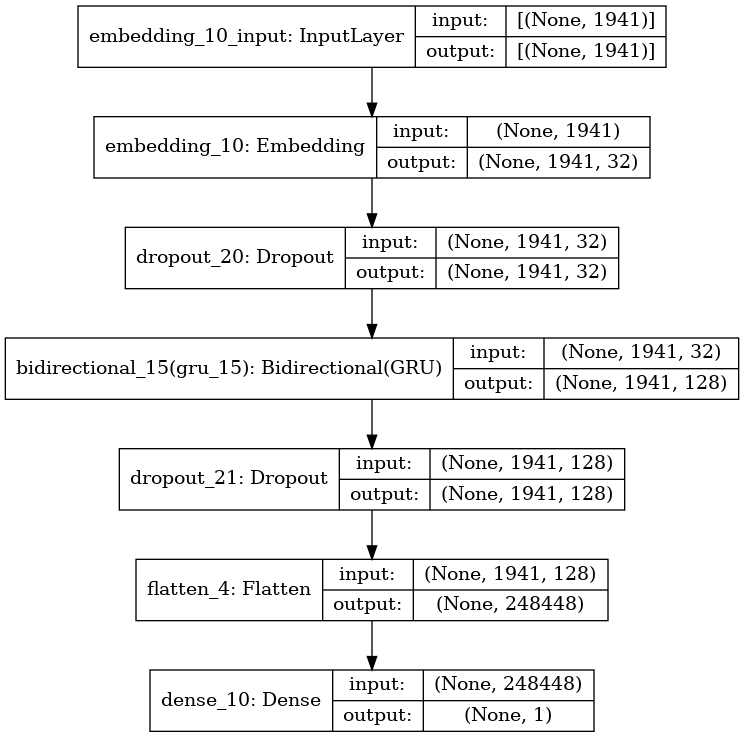

In [160]:
grumodel2 = build_BiGRU_2(EMBED_DIM)
show_model_summary(grumodel2)
plot_model(grumodel2,show_shapes=True)

In [161]:
gruhistory2 = fit_model(grumodel2,'./saved_model/grumodel2.h5')
plot_PM(gruhistory2)
gru_results2 = grumodel2.evaluate(pad_test_seq,y_test)
gru_results2

Epoch 1/20
27/27 [==============================] - 236s 9s/step - loss: 0.6078 - accuracy: 0.7300 - auc: 0.5343 - val_loss: 0.5388 - val_accuracy: 0.7511 - val_auc: 0.7084
Epoch 2/20
27/27 [==============================] - 228s 8s/step - loss: 0.4876 - accuracy: 0.7644 - auc: 0.8205 - val_loss: 0.3268 - val_accuracy: 0.8683 - val_auc: 0.9252
Epoch 3/20
27/27 [==============================] - 229s 8s/step - loss: 0.2722 - accuracy: 0.8893 - auc: 0.9367 - val_loss: 0.2302 - val_accuracy: 0.9042 - val_auc: 0.9545
Epoch 4/20
27/27 [==============================] - 228s 8s/step - loss: 0.1948 - accuracy: 0.9233 - auc: 0.9680 - val_loss: 0.2195 - val_accuracy: 0.9119 - val_auc: 0.9586
Epoch 5/20
27/27 [==============================] - 228s 8s/step - loss: 0.1548 - accuracy: 0.9409 - auc: 0.9794 - val_loss: 0.2266 - val_accuracy: 0.9134 - val_auc: 0.9561
Epoch 6/20
27/27 [==============================] - 228s 8s/step - loss: 0.1288 - accuracy: 0.9517 - auc: 0.9854 - val_loss: 0.2359 - v

129/129 [==============================] - 103s 795ms/step - loss: 0.3050 - accuracy: 0.8963 - auc: 0.9377


[0.3050122559070587, 0.8963161706924438, 0.9377371072769165]